**Module Paths**

In [1]:
import sys
sys.path.append('../../../')

# Importing necessary modules

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import DataLoader
from typing import Tuple
from data import DatasetWrapper, DataLoaderWrapper
from criterion import CriterionWrapper
from optimize import OptimizerWrapper
from trainer import CNNTrainer
from data.helper import calculate_mean_std
from utils.device import get_device

# MLP

In [3]:
device = get_device()

## Define the MLP model

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

## Load the Data

First, initialize without normalization to calculate mean and std

In [5]:
initial_transform = T.Compose([T.ToTensor()])

Create a dataset for calculating mean and std

In [6]:
dataset_wrapper = DatasetWrapper(dataset_name='MNIST', root='./data', train_transform=initial_transform, download=True)
train_dataset, _ , _ = dataset_wrapper.get_datasets()

In [7]:
mean, std = calculate_mean_std(train_dataset, device=device)
print("Calculated Mean:", mean)
print("Calculated Std:", std)

Calculated Mean: tensor([0.1307])
Calculated Std: tensor([0.3016])


Now update the transforms to include normalization

In [8]:
final_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean.tolist(), std.tolist())
])

Update Dataset with normalized transforms

In [9]:
dataset_wrapper = DatasetWrapper(dataset_name='MNIST', root='./data', train_transform=final_transform, download=True)

## Create DataLoader

In [10]:
train_dataset, val_dataset, _ = dataset_wrapper.get_datasets()

train_loader_wrapper = DataLoaderWrapper(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader_wrapper = DataLoaderWrapper(dataset=val_dataset, batch_size=64, shuffle=False)

train_loader = train_loader_wrapper.get_loader()
val_loader = val_loader_wrapper.get_loader()

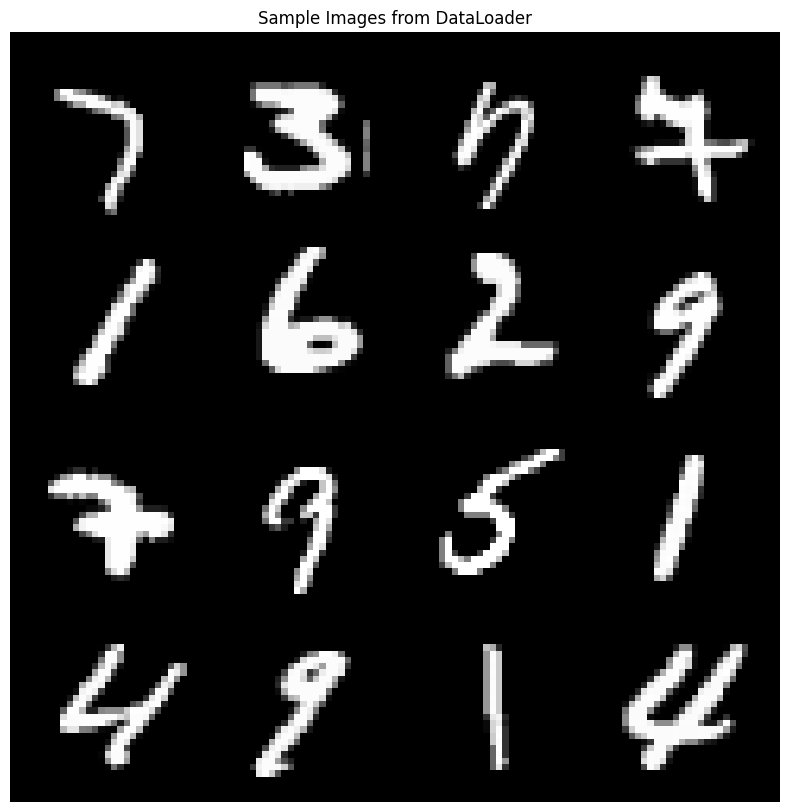

In [11]:
train_loader_wrapper.display_sample_images()

## Initialize model, criterion, optimizer

In [12]:
# Model
model = MLP()

# Criterion
criterion_wrapper = CriterionWrapper(criterion_name='cross_entropy')
criterion = criterion_wrapper.get_criterion()

# Optimizer
optimizer_wrapper = OptimizerWrapper(model=model, optimizer_name='adam', lr=0.001)
optimizer = optimizer_wrapper.get_optimizer()

## Train the model

In [13]:
trainer = CNNTrainer(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, device=device)

In [14]:
# Train the model for a few epochs
trainer.train(num_epochs=5, save_path='./best_mlp_mnist_model.pth')

Epoch 1/5, Train Loss: 0.2809, Val Loss: 0.1497, Val Accuracy: 95.54%
Best model saved with val loss: 0.1497
Epoch 2/5, Train Loss: 0.1180, Val Loss: 0.1167, Val Accuracy: 96.60%
Best model saved with val loss: 0.1167
Epoch 3/5, Train Loss: 0.0831, Val Loss: 0.1034, Val Accuracy: 96.99%
Best model saved with val loss: 0.1034
Epoch 4/5, Train Loss: 0.0630, Val Loss: 0.0993, Val Accuracy: 97.15%
Best model saved with val loss: 0.0993
Epoch 5/5, Train Loss: 0.0491, Val Loss: 0.0955, Val Accuracy: 97.28%
Best model saved with val loss: 0.0955


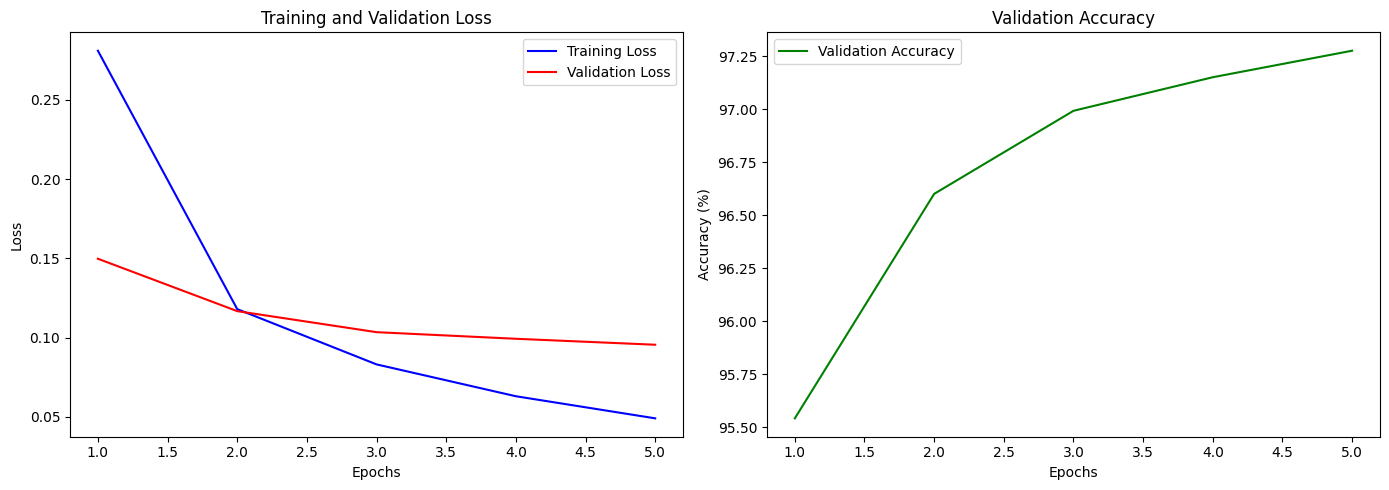

In [15]:
# Plot the trainer metrics
trainer.plot_metrics()

**The MLP model did exceptionally well with MNIST due to the dataset’s simplicity and structure, which aligns perfectly with the strengths of a fully connected architecture.**

1.	Simplicity of the Data:
    - MNIST images are low-complexity, grayscale 28x28 pixel images, making it easier for MLPs to capture essential information without spatial filters.
    - The uniform background helps MLPs focus on the digit pattern itself without noise or distractions.
2.	Centered and Well-Positioned Digits:
    - Digits are centered, reducing variability in feature location, so the model doesn’t need to handle spatial shifts or rotations.
    - With consistent scaling and positioning, MLPs can differentiate digits without convolutional layers designed to handle variations.
3.	Sufficient Contrast:
    - MNIST images are binary-like, with clear distinctions between foreground (digit) and background, making it easier for an MLP to learn patterns.
    - The high contrast means edge detection is less necessary, allowing the MLP to classify patterns without edge-detecting filters.
5.	Limited Spatial Relationships:
    - Each digit can be recognized by global patterns, which MLPs can capture across the flattened input without needing local spatial relationships.
	- Translational invariance is unnecessary since MNIST digits are centered, so MLPs can perform well without this convolutional benefit.
6.	Small Input Size:
    -	The 28x28 images provide a manageable input size (784 pixels) for MLPs to process as a single flattened vector.
    -   Larger images with more complex spatial patterns would require convolutions for computational efficiency and effective local pattern capture.

Let’s add some data augmentation to introduce variability in our MNIST dataset, simulating more challenging conditions that can help us explore the limitations of an MLP without convolutional layers

In [16]:
train_transforms = T.Compose(
    [   
        # Apply random affine transformations with rotation and translation for off-center positioning
        T.RandomAffine(degrees=15, translate=(0.3, 0.3)),
        
        # Apply a small amount of Gaussian blur to introduce blur variability
        T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
        
        # Convert to tensor and normalize with calculated mean and std
        T.ToTensor(),
        T.Normalize(mean.tolist(), std.tolist())
    ]
)

Update dataset and dataloader with new transformation

In [17]:
dataset_wrapper = DatasetWrapper(dataset_name='MNIST', root='./data', train_transform=train_transforms, download=True)

In [18]:
train_dataset, val_dataset, _ = dataset_wrapper.get_datasets()

train_loader_wrapper = DataLoaderWrapper(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader_wrapper = DataLoaderWrapper(dataset=val_dataset, batch_size=64, shuffle=False)

train_loader = train_loader_wrapper.get_loader()
val_loader = val_loader_wrapper.get_loader()

Visualizing new training images

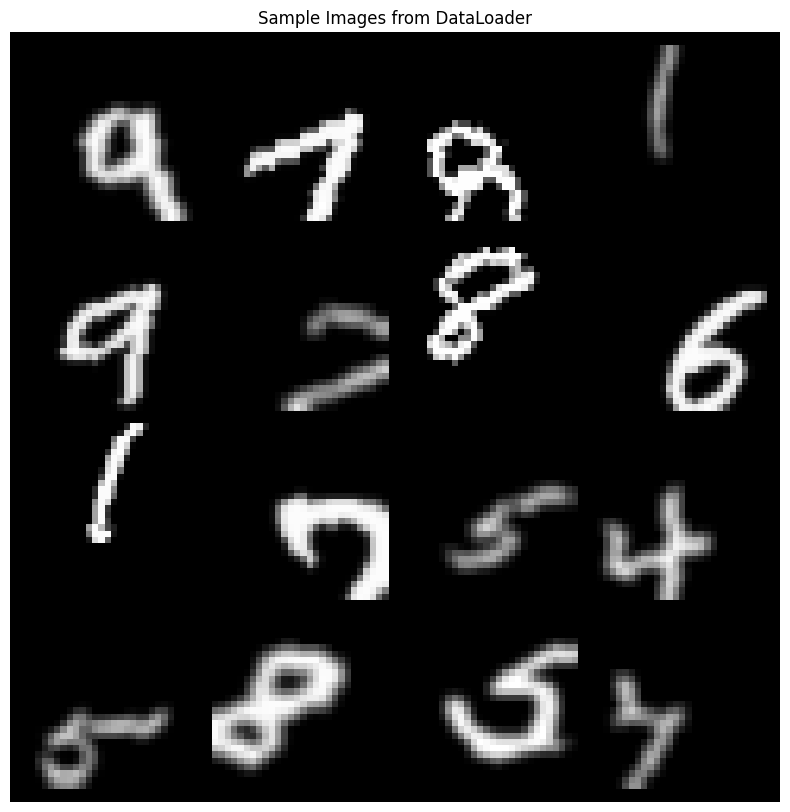

In [19]:
train_loader_wrapper.display_sample_images()

In [20]:
trainer = CNNTrainer(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, device=device)

In [21]:
# Train the model for a few epochs
trainer.train(num_epochs=5, save_path='./best_mlp_mnist_model.pth')

Epoch 1/5, Train Loss: 1.0200, Val Loss: 0.6876, Val Accuracy: 78.12%
Best model saved with val loss: 0.6876
Epoch 2/5, Train Loss: 0.5482, Val Loss: 0.4943, Val Accuracy: 84.23%
Best model saved with val loss: 0.4943
Epoch 3/5, Train Loss: 0.4585, Val Loss: 0.4496, Val Accuracy: 86.02%
Best model saved with val loss: 0.4496
Epoch 4/5, Train Loss: 0.4231, Val Loss: 0.4151, Val Accuracy: 86.77%
Best model saved with val loss: 0.4151
Epoch 5/5, Train Loss: 0.3922, Val Loss: 0.4080, Val Accuracy: 87.60%
Best model saved with val loss: 0.4080


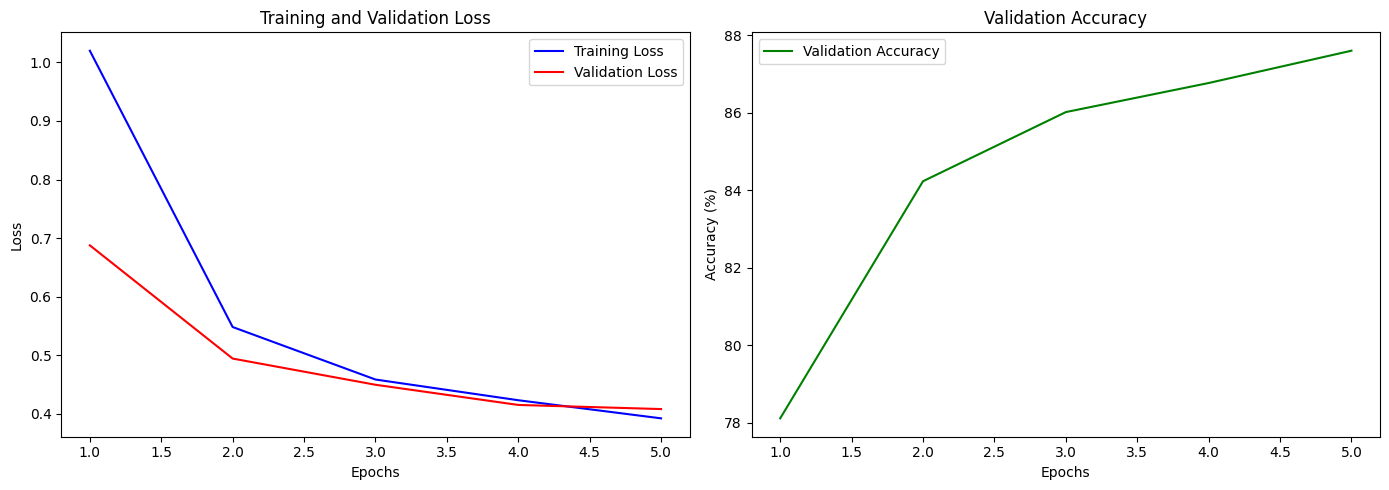

In [22]:
# Plot the trainer metrics
trainer.plot_metrics()